In [39]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import yfinance as yfin

We will explore the application of Monte Carlo simulation in the valuation of financial derivatives. The mathematical notation and illustrations in this exploration are drawn from the book "Implementing Derivatives Models" by Les Clewlow and Chris Strickland.

Valuing financial derivatives through Monte Carlo simulations relies on employing the principles of Risk-Neutral Pricing in financial mathematics and simulating risk-neutral asset paths.

## $$\frac{C_t}{B_t} = \mathbb{E}_{\mathbb{C}}[\frac{C_t}{B_t} \mid F_{t}]$$


 $\frac{C_t}{B_t}$: This ratio is used to determine the relative value of the financial derivative $C_t$ in comparison to a riskless bond or bank account $B_t$. It provides a way to measure the relative worth of the derivative compared to a risk-free investment.

$\mathbb{E}_{\mathbb{C}}[...]$: The symbol $\mathbb{E}_{\mathbb{C}}$ represents the expectation operator with respect to a specific probability measure, often denoted as $\mathbb{C}$. In the context of financial derivatives, this probability measure is often the risk-neutral measure, which is a mathematical tool used to value derivatives. The expectation operator calculates the average value of what is inside the square brackets.

$\mid F_{t}$: The vertical bar ($\mid$) followed by $F_t$ represents a conditional expectation. It indicates that the expected value is calculated based on the information available at time $F_t$. In the context of financial derivatives, $F_t$ represents the information or events up to time $t$. So, the conditional expectation evaluates the ratio $\frac{C_t}{B_t}$ based on what is known up to time $t$, typically in a risk-neutral framework.

Monte Carlo simulations are a computational technique employed to tackle probabilistic challenges by generating a large number of possible scenarios. This enables the calculation of statistical characteristics of the results, including expected values, variances, and the likelihood of specific outcomes.

In the context of Financial Derivatives, Monte Carlo simulations serve as a valuable tool for pricing intricate derivatives where analytical formulas are impractical or unavailable. This approach was first introduced by Boyle in 1977 and has since provided a straightforward approach for handling multiple sources of randomness. Additionally, it facilitates the inclusion of more realistic asset price behaviors, such as jumps in asset prices.

**Monte Carlo as a Tool**

Monte Carlo simulations serve as a versatile tool in financial analysis, addressing two main types of financial challenges:

**1. Portfolio Metrics (Using Brownian Motion to represent real probabilities under the P-measure):**
- Estimating expected returns
- Evaluating risk measures such as Value at Risk (VaR), Conditional VaR (CVaR), and more
- Assessing downside risks, including metrics like drawdowns
- Analyzing various probabilities of interest

**2. Derivative Pricing through Risk-Neutral Valuation (Leveraging Brownian Motion to represent risk-neutral probabilities under the Q-measure):**
- Determining the fair prices of derivatives within a risk-neutral framework


In [40]:


# function to get data
def get_data(stocks, start, end):
    yfin.pdr_override()
    stock_data = pdr.get_data_yahoo(stocks, start, end)
    stock_data = stock_data['Adj Close']  # 'Adj Close' for adjusted closing prices
    returns = stock_data.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return mean_returns, cov_matrix

# list of stock symbols without the '.AX' suffix
stock_list = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']

# Add '.AX' suffix to stock symbols
stocks = [stock + '.AX' for stock in stock_list]

# Define the end date as the current date and calculate the start date
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=300)

# Call the get_data function to fetch and analyze the stock data
mean_returns, cov_matrix = get_data(stocks, start_date, end_date)

# Generate random weights for the portfolio
weights = np.random.random(len(mean_returns))
weights /= np.sum(weights)

# Print the results
print("Mean Returns:")
print(mean_returns)
print("\nCovariance Matrix:")
print(cov_matrix)
print("\nRandom Weights for the Portfolio:")
print(weights)


[*********************100%%**********************]  6 of 6 completed
Mean Returns:
BHP.AX    0.000148
CBA.AX    0.000056
NAB.AX   -0.000039
STO.AX    0.000733
TLS.AX   -0.000013
WBC.AX   -0.000358
dtype: float64

Covariance Matrix:
          BHP.AX    CBA.AX    NAB.AX    STO.AX    TLS.AX    WBC.AX
BHP.AX  0.000196  0.000036  0.000047  0.000073  0.000010  0.000046
CBA.AX  0.000036  0.000100  0.000095  0.000037  0.000021  0.000090
NAB.AX  0.000047  0.000095  0.000140  0.000046  0.000028  0.000108
STO.AX  0.000073  0.000037  0.000046  0.000199  0.000014  0.000040
TLS.AX  0.000010  0.000021  0.000028  0.000014  0.000064  0.000023
WBC.AX  0.000046  0.000090  0.000108  0.000040  0.000023  0.000119

Random Weights for the Portfolio:
[0.14122514 0.23875168 0.15154895 0.30046956 0.1531306  0.01487407]


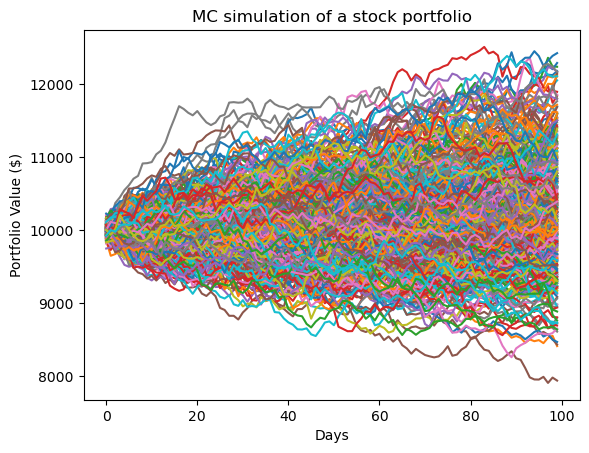

In [42]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days
meanM = np.full(shape=(T, len(weights)), fill_value=mean_returns)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(cov_matrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [43]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")
def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
        
        
portResults = pd.Series(portfolio_sims[-1,:])
VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)
print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))

VaR_5 $1014.41
CVaR_5 $1293.05


**Computationally Inefficient but Versatile**

In terms of computational efficiency, Monte Carlo simulations, in their basic form, are relatively less efficient when compared to the straightforward analytical formulas available for deterministic partial differential equations (PDEs). An example of this is the Black-Scholes option pricing model for European Options, which provides a more efficient analytical solution. However, the primary rationale for adopting Monte Carlo simulations lies in their capability to value complex derivatives for which analytical formulas are often elusive.

Nevertheless, there are strategies to enhance the accuracy and efficiency of Monte Carlo simulations:

**1. Variance Reduction Methods:**
   - **Antithetic Variates:** This method involves generating paired random samples in a way that their average has reduced variance, significantly enhancing the efficiency of Monte Carlo simulations.
   - **Control Variates:** In this technique, known results or analytical values are used as references to control and adjust simulation results, reducing variance and improving accuracy.

**2. Quasi-Random Numbers (Deterministic Sequences):**
   - Compared to pseudo-random numbers, quasi-random numbers follow a more deterministic pattern and are distributed more evenly in the sample space. This can lead to faster convergence and increased computational efficiency in Monte Carlo simulations.

These strategies enable Monte Carlo simulations to be more accurate and efficient, making them a valuable tool for pricing complex derivatives, despite their basic inefficiency in comparison to analytical solutions for simpler cases.


**Valuation by Simulation**

The risk-neutral pricing methodology informs us that the value of an option can be expressed as the risk-neutral expectation of its discounted payoff. We can estimate this expectation by computing the average of a large number of discounted payoffs. For a particular simulation, denoted as $i$, this process can be outlined as follows:


- For option valuation at time 0 in a specific simulation $i$:
  - The present value is given by: 
    $$C_{0,i} = \exp{(-\int_{0}^{T} r_s \, ds)} \cdot C_{T,i}$$

- Here, $C_{0,i}$ is the present value at time 0, and $C_{T,i}$ is the future value at time T. The integral represents the cumulative interest rate from time 0 to time T, and $r_s$ represents the interest rate as a function of time "s."

- A simplified form of this equation is:
  $$C_{0,i} = \exp{(-rT)} \cdot C_{T,i}$$

- In this simplified version, $C_{0,i}$ is the present value at time 0, $C_{T,i}$ is the future value at time T, and $r$ is the constant interest rate.


**Averaging Simulated Outcomes**

When we repeat the simulation $M$ times, we can calculate the average of the outcomes as follows:

- Average option value at time 0:
  $$\hat{C}_0 = \frac{1}{M} \sum_{i=1}^{M} C_{0,i}$$

**Estimating the Standard Error**

$\hat{C}_0$ represents an estimate of the true value of the option $C_0$. However, this estimate carries an inherent error due to the fact that it is an average of randomly generated samples. As a result, the calculation itself is subject to randomness.

A measure of this error is the standard deviation of $\hat{C}_0$, known as the standard error. The standard error can be estimated as the standard deviation of $C_{0,i}$ divided by the number of samples, which is $M$. This can be expressed as:


**Calculating the Standard Error and Sample Standard Deviation**

To compute the standard error $SE(\hat{C}_0)$ and the sample standard deviation $\sigma(C_{0,i})$, you can use the following formulas:

1. Standard Error:
   $$SE(\hat{C}_0) = \frac{\sigma(C_{0,i})}{\sqrt{M}}$$
   
2. Sample Standard Deviation:
   $$\sigma(C_{0,i}) = \sqrt{\frac{1}{M-1} \sum_{i=1}^{M} (C_{0,i} - \hat{C}_0)^2}$$

In these formulas:
- $SE(\hat{C}_0)$ represents the standard error of the estimate.
- $\sigma(C_{0,i})$ is the sample standard deviation of $C_{0,i}$.
- $\hat{C}_0$ is the average of the simulated option values at time 0.
- $M$ is the number of simulations.

These calculations help quantify the uncertainty associated with our estimated option value.


**European Call Option in the Black-Scholes World**

In the context of valuing European Call Options within the Black-Scholes framework, where a constant interest rate is assumed (denoted as $r$), the discount factor is expressed as $\exp(-rT)$. The dynamics of the stock price are modeled using Geometric Brownian Motion (GBM) and can be described by the following stochastic differential equation (SDE):

$$dS_t = rS_t dt + \sigma S_t dW_t$$

To simulate this GBM process, we can simulate the variables of the natural logarithm process of the stock price, denoted as $x_t = \ln(S_t)$ which follows a normal distribution. The dynamics of the natural logarithm process of stock prices under the GBM model involve the use of Itô's calculus and can be represented as:

$$dx_t = \nu d t + \sigma d z_t, \nu = r - \frac{1}{2}\sigma^2$$

To discretize this stochastic differential equation (SDE) and transition from infinitesimal changes $dx, dt, dz$ to small steps $\Delta{x}, \Delta{t}, \Delta{z}$, we use the following exact solution:

$$\Delta x = \nu \Delta t + \sigma \Delta z$$


This equation provides an exact solution to the SDE without any approximation.

$$x_{t+\Delta{t}} = x_t + \nu(\Delta{t}) + \sigma (z_{t+\Delta{t}}- z_t )$$



In terms of the stock price $S$ we have:

$$S_{t+\Delta t} = S_t \exp(\nu \Delta t + \sigma (z_{t+\Delta{t}}- z_t ))$$




Where

$$(z_{t+\Delta t} - z_t) \sim \mathcal{N}(0, \Delta t)$$

We can also express it as a standard normal distribution scaled by $\sqrt{\Delta t}$:

$$\sqrt{\Delta t} \cdot (z_{t+\Delta t} - z_t) \sim \mathcal{N}(0, 1)$$

Here, we introduce the random variable $ε_i to$ represent this standard normal distribution, such that:

$$\sqrt{\Delta t} \cdot (z_{t+\Delta t} - z_t) = \sqrt{\Delta t} \cdot \epsilon_i$$

This $ε_i$ follows a standard normal distribution with mean 0 and variance 1, and it is a critical component of the simulation process.

In [50]:
# initial derivative parameters 
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.01            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations
market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


*Slow Solution*

In [51]:
# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0
# Monte Carlo Method
for i in range(M):
    lnSt = lnS
    for j in range(N):
        lnSt = lnSt + nudt + volsdt*np.random.normal()
    
    ST = np.exp(lnSt)
    CT = max(0, ST - K)
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT
# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $4.01 with SE +/- 0.11


*Fast Solution - Vectorized*

In [52]:
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M
sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.45 with SE +/- 0.1


**Simulation of Variables in Simple Processes**

In the case of simple processes, such as the Geometric Brownian Motion used for calculating the price of a European Option, there is no need to approximate the stochastic differential equation (SDE). This is because processes like Geometric Brownian Motion scale with time and exhibit independent increments.

As a result, in these cases, we can efficiently simulate the variables at the final time step without the need for further approximation. This is because Brownian Motion, which underlies these processes, exhibits these desirable characteristics of time scaling and independent increments.

This simplifies the simulation process and allows for accurate estimation of the option's price, making it a valuable approach for European Option pricing.


In [54]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M
sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.76 with SE +/- 0.11


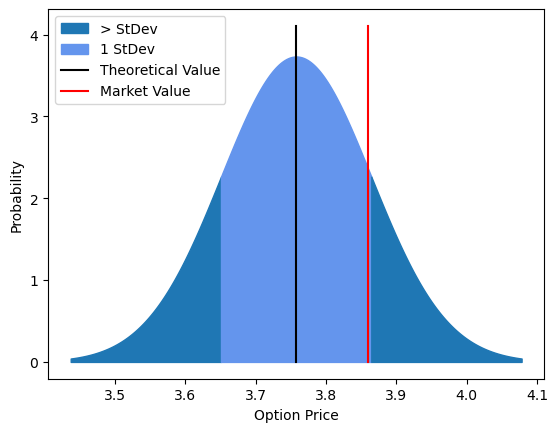

In [55]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')
plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()